In [1]:
!python --version
import os
import warnings
print (os.environ['CONDA_DEFAULT_ENV'])

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16
py310_pymc_env2_linux


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 62.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34671,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 62.53 GiB
Comm: tcp://127.0.0.1:46231,Total threads: 2
Dashboard: http://127.0.0.1:45761/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:38793,


# 1. Workbook setups

## 1.1 Import packages

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import xarray as xr
xr.set_options(file_cache_maxsize=10)


import seaborn as sns

import scipy as scipy
from scipy import stats
from scipy import signal
from scipy.integrate import trapz
import math
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error


from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import cmocean.cm as cmo


import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat
import pygplates

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import copernicusmarine

## 1.2 Miscellaneous codes

In [3]:
def _woa_variable(variable):
    '''
    codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
    variables:
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M"
   time_periods:
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
   resolutions:
    '5': ('5deg', '5d'),
    '1': ('1.00', '01'),
    '04': ('0.25', '04'),
        

    an=Objectively analyzed climatologies are the objectively interpolated mean fields 
    for oceanographic variables at standard depth levels for the World Ocean.
    mn=The statistical mean is the average of all unflagged interpolated values at each 
    standard depth level for each variable in each 1° square which contains at least one
    '''
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M02"
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base2 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa18'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif variable == "temperature":
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base2}'
        f'{variable}/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

##### WOA23 Data base url loader #############
def _woa23_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base_woa23 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa23'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif ((variable == "temperature") or (variable == "salinity")):
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base_woa23}'
        f'{variable}/netcdf/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [4]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

## 1.4 Set local paths

In [5]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie/OneDrive'

# 2. Import data

## 2.1 Coretop compilation

In [6]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = r'texmarine-revised-2024.csv'

coretop_df = pd.read_csv(os.path.join(fpath,fname))

coretop_df = coretop_df.rename(
    columns={
        'latitude':'Latitude',
        'longitude':'Longitude',
        'depth':'modernWaterDepth',
        'tex86':'TEX86',
        'bit':'BIT'
    }
)

#### Additional parameters
coretop_df['publicationYear'] = [int(row[-4:]) if row[-4:].isdigit() else 'This Study' for row in coretop_df['reference_name']]

features = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_zhang16'] = np.array([coretop_df[features[i]]*ringNumbers_dict_zhang16.get(features[i]) for i in range(len(features))]).sum(axis=0)
coretop_df['RI_zhang16_revised'] = np.array([coretop_df[features[i]]*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)


features2 = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_0to5'] = np.array([coretop_df[features2[i]]*ringNumbers_dict_revised.get(features2[i]) for i in range(len(features2))]).sum(axis=0)

coretop_df['gdgt23ratio'] = coretop_df['fGDGT_2']/coretop_df['fGDGT_3']
coretop_df['methaneIndex'] = coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3']].sum(axis=1)/coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']].sum(axis=1)
coretop_df['gdgtZeroOverZeroCren'] = (coretop_df['fGDGT_0']/coretop_df[['fGDGT_0','fGDGT_cren']].sum(axis=1))

temp_sampleID = ['TEXAS_PSM_RR'+str(i).zfill(5) for i in range(1,len(coretop_df)+1)]
coretop_df.insert(0,'sampleID',temp_sampleID)

#### copy coretop_df to coretop_df2 to keep the original df
coretop_df2 = coretop_df.dropna(how='any', subset=['TEX86','fGDGT_0']).reset_index(drop=True)
coretop_df2['BIT'] = coretop_df2['BIT'].fillna(-999)
coretop_df2['methaneIndex']= coretop_df2['methaneIndex'].fillna(-999)
coretop_df2['gdgtZeroOverZeroCren'] = coretop_df2['fGDGT_0'].fillna(-999)


coretop_df2['QC_flag'] = ['include' if ((coretop_df2['BIT'].iloc[i] <= 0.5) & (coretop_df2['methaneIndex'].iloc[i] <= 0.5) & (coretop_df2['gdgtZeroOverZeroCren'].iloc[i] <= 0.67)) else 'exclude' for i in range(len(coretop_df2))]
coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,reference_name,remark,reference_link,RI_zhang16,RI_zhang16_revised,RI_0to5,gdgt23ratio,methaneIndex,gdgtZeroOverZeroCren,QC_flag
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,this study,NaN,NaN,2.341606,2.874369,2.874369,13.185451,0.204131,0.330589,include
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,this study,NaN,NaN,2.566525,3.158231,3.158231,4.882710,0.175419,0.282415,include
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,this study,NaN,NaN,2.503135,3.072126,3.072126,4.409615,0.196327,0.292011,include
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,this study,NaN,NaN,2.427417,2.980611,2.980611,6.868635,0.199117,0.309270,include
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,this study,NaN,NaN,2.248913,2.751584,2.751584,8.430655,0.233462,0.344233,include
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,Wei2020,Data from original source,NaN,2.601000,3.170000,3.170000,3.000000,0.255236,0.236000,include
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,Wei2020,Data from original source,NaN,2.525000,3.099000,3.099000,2.941176,0.201669,0.281000,include
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,Wei2020,Data from original source,NaN,2.652000,3.244000,3.244000,3.090909,0.225131,0.236000,include
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,Wei2020,Data from original source,NaN,2.647000,3.235000,3.235000,3.714286,0.229358,0.237000,include


## 2.2 Ocean products

### 2.2.1 WOA23 - Temperature 0.25deg x 0.25deg

WOA = World Ocean Atlas
Details:
- Temperature - Statistical mean on 1/4° grid for 1971-2000 climate normal
- Unit: Degree Celcius
- Link to download data: https://www.ncei.noaa.gov/thredds-ocean/fileServer/woa23/DATA/temperature/netcdf/decav71A0/0.25/woa23_decav71A0_t00_04.nc

In [7]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_01.nc'),decode_times=False).drop('time')

T_da_01 = ts.isel(time=0).t_an.load()
T_da_01


<xarray.DataArray 't_an' (depth: 102, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.64341  , -1.64421  , -1.64491  , ..., -1.64151  ,
         -1.64201  , -1.64271  ],
        [-1.63731  , -1.63671  , -1.6371   , ..., -1.64641  ,
         -1.63721  , -1.63721  ],
        [-1.62861  , -1.62861  , -1.62861  , ..., -1.62861  ,
         -1.62861  , -1.62861  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [8]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.64081  , -1.64411  , -1.64031  , ..., -1.66391  ,
         -1.6435   , -1.64231  ],
        [-1.6669   , -1.66691  , -1.66691  , ..., -1.66681  ,
         -1.66681  , -1.66681  ],
        [-1.66871  , -1.66871  , -1.66871  , ..., -1.66871  ,
         -1.66871  , -1.66871  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [9]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_integral_04degReso_revised.nc'
thermocline_T_integral_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_integral.load()
thermocline_T_integral_da

<xarray.DataArray 'thermo_integral' (lat: 720, lon: 1440)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-1.48574126, -1.48628342, -1.48646832, ..., -1.48584414,
        -1.48539674, -1.48565447],
       [-1.49165857, -1.4918884 , -1.49210393, ..., -1.49090397,
        -1.4911027 , -1.49129009],
       [-1.49897289, -1.49897289, -1.49897289, ..., -1.49897289,
        -1.49897289, -1.49897289]])
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0
    time     float32 1.878e+03

In [10]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_depth_04degReso_revised.nc'

thermocline_depth_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_depth.load()
thermocline_depth_da

<xarray.DataArray 'thermo_depth' (lat: 720, lon: 1440)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [175., 175., 175., ..., 175., 175., 175.],
       [175., 175., 175., ..., 175., 175., 175.],
       [175., 175., 175., ..., 175., 175., 175.]])
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0
    time     float32 1.878e+03

#### Calculate gridded thermocline depth and depth-integrated thermocline T with xarray

In [11]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sliced_T_da = T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_depth_values = thermoT_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_values = thermoT_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_depth_da = thermoT_depth_values.unstack("grid")
thermoT_da = thermoT_values.unstack("grid")
masked_T_da = T_da.where(T_da["depth"]<=thermoT_depth_da)


In [85]:
len_notnull_values_along_depth = np.unique(masked_T_da.notnull().sum('depth').values)
sel_masked_da = masked_T_da
tmp_da = xr.DataArray(np.zeros_like(sel_masked_da.isel(depth=0).values),
                      dims=sel_masked_da.isel(depth=0).dims,
                      coords=sel_masked_da.isel(depth=0).coords
                      )
tmp_da
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = sel_masked_da.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        
        # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
tmp_da2 = tmp_da
#### mask locations where there are more than 1 valid depth values
mask_below_SST = sel_masked_da.notnull().sum('depth') > 1
cal_values = tmp_da2.where(mask_below_SST)/thermoT_depth_da.where(mask_below_SST)
# apply mask where all depth values are NaN
all_nan_mask = np.isnan(sel_masked_da).all('depth')
tmp_da2 = tmp_da2.where(~all_nan_mask)

thermocline_depthIntegral_T_da = tmp_da2.where(~mask_below_SST, other=cal_values)
thermocline_depthIntegral_T_da

<xarray.DataArray (lat: 720, lon: 1440)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.3260654, -1.3265443, -1.3267593, ..., -1.3259107, -1.3255987,
        -1.3259116],
       [-1.3309795, -1.3312201, -1.3314477, ..., -1.3301692, -1.3303967,
        -1.3306143],
       [-1.3382853, -1.3382853, -1.3382853, ..., -1.3382853, -1.3382853,
        -1.3382853]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0

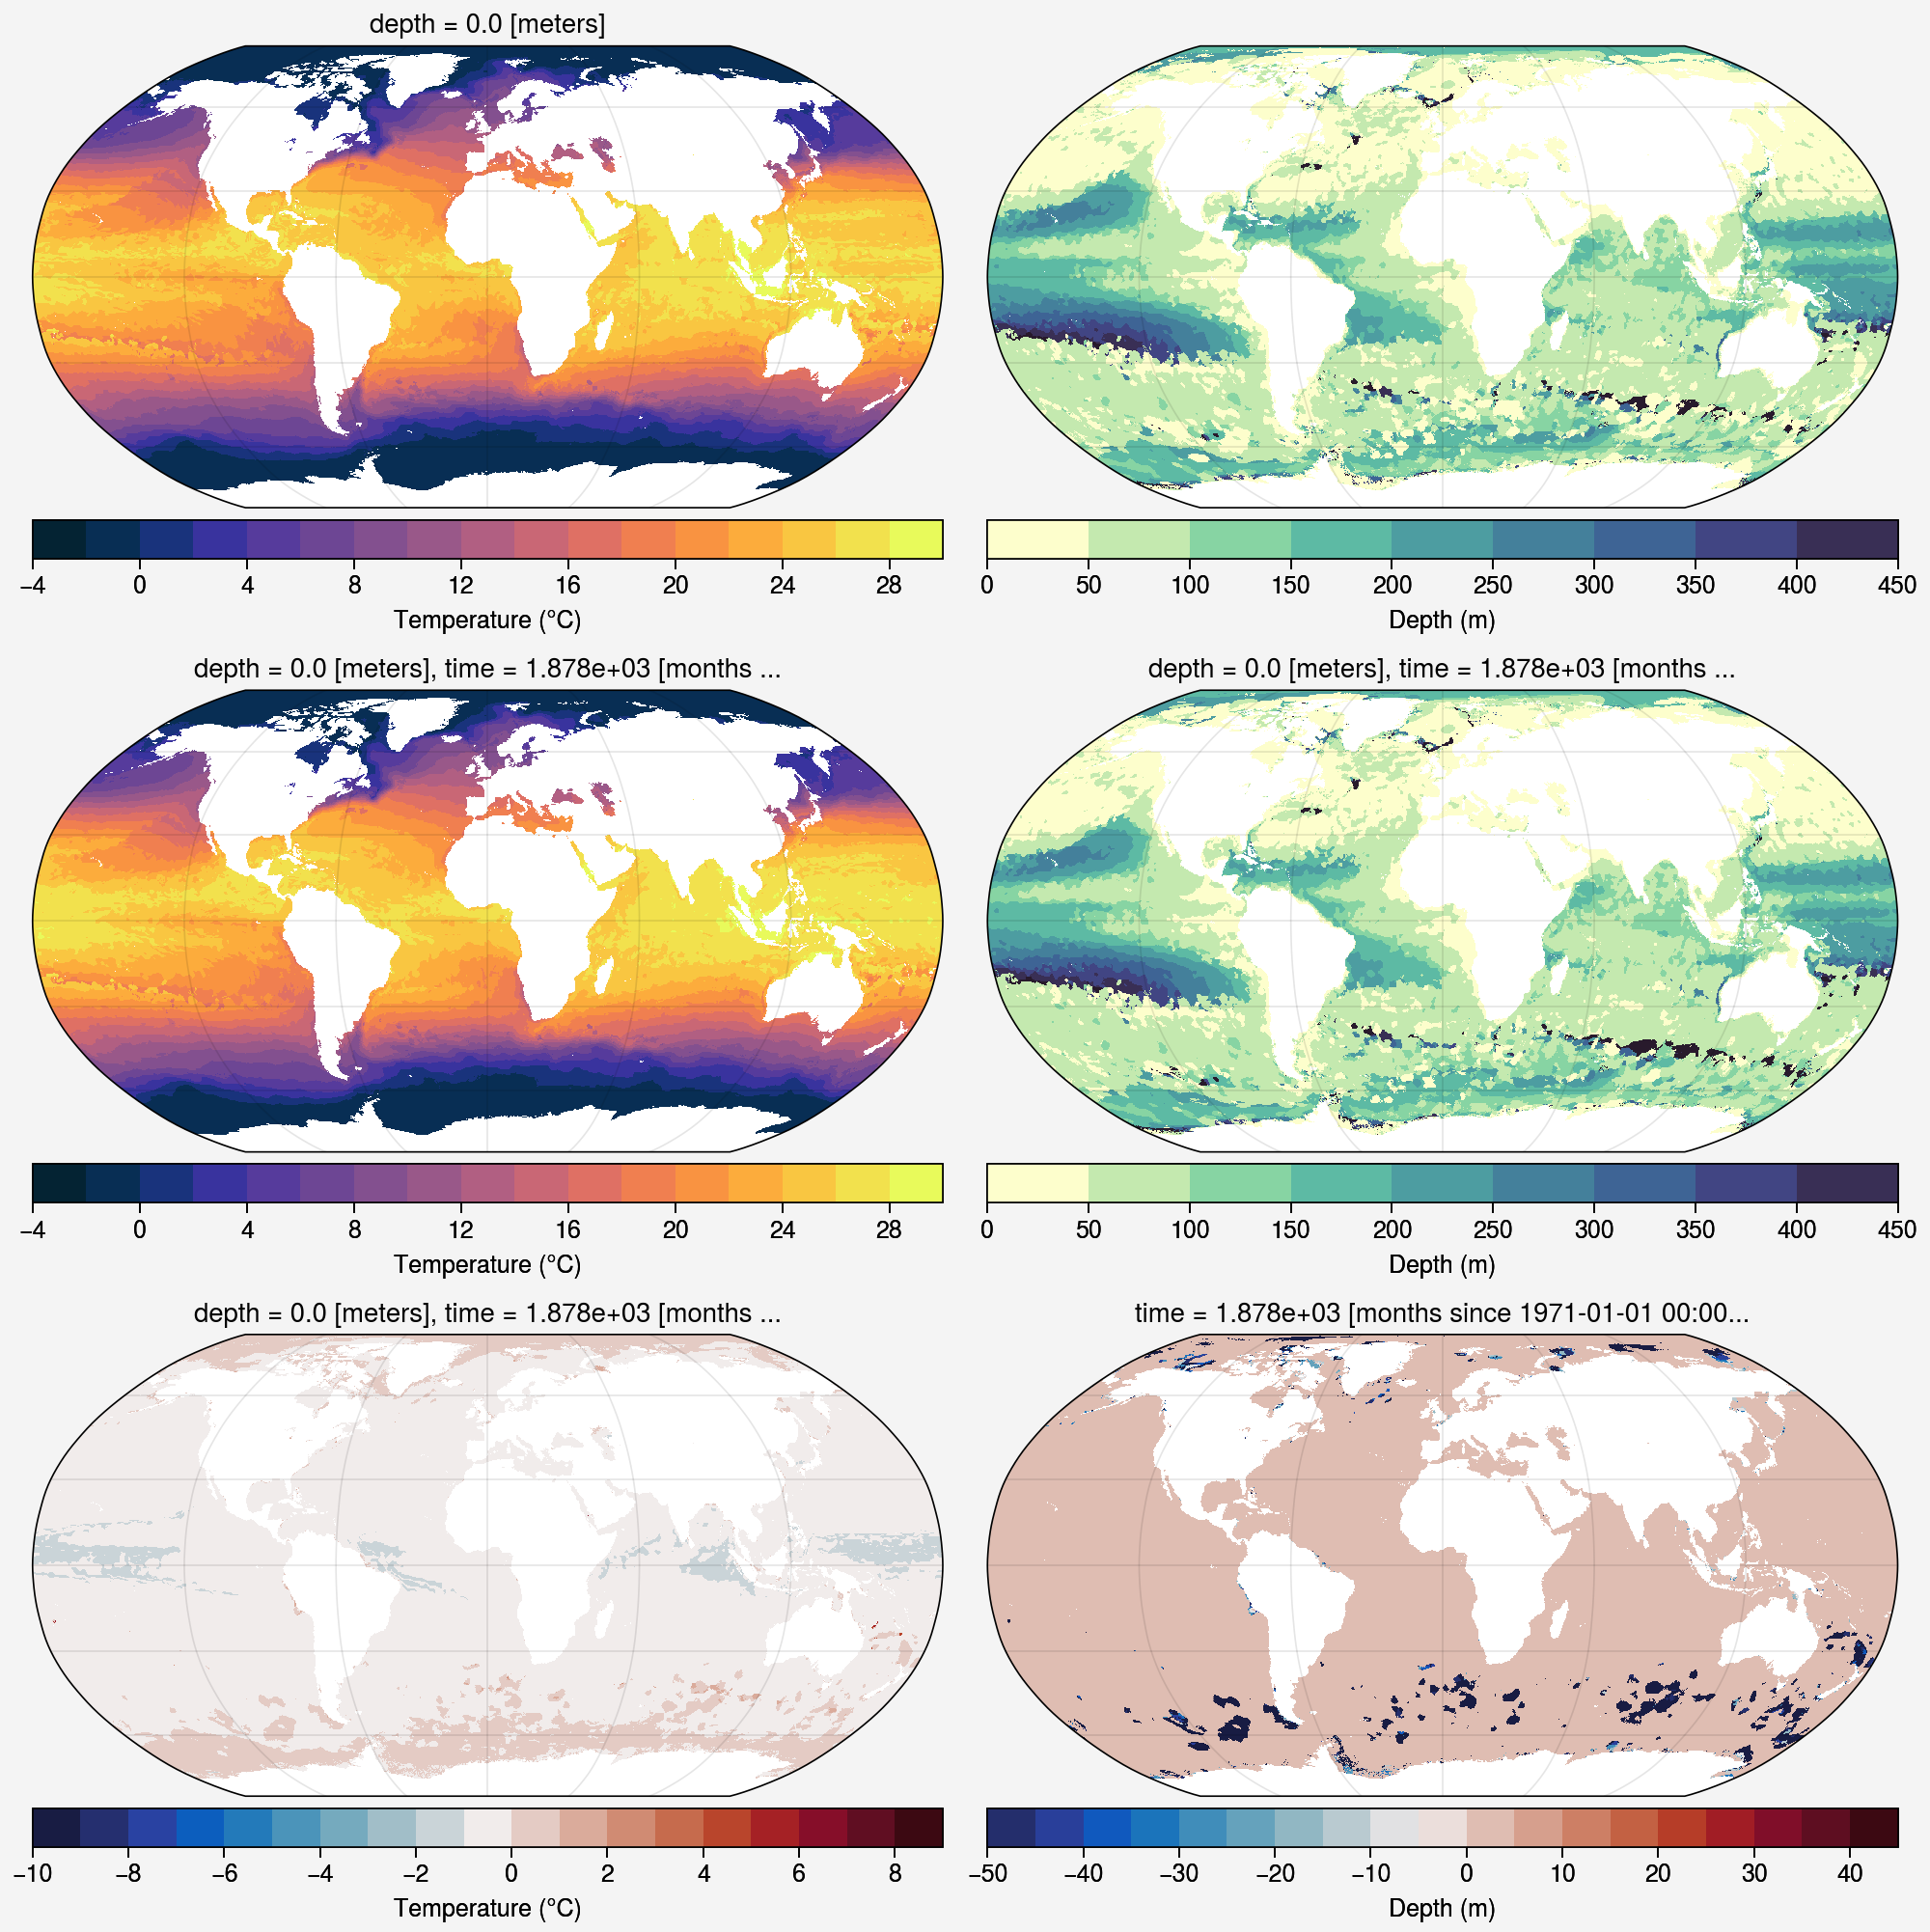

In [86]:
fig, axs = plot.subplots(proj='robin',width=10,nrows=3,ncols=2)
ax = axs[0,0]

m = thermocline_depthIntegral_T_da.plot(ax=ax,
                        cmap='cmo.thermal',
                        add_colorbar=False,
                        levels=np.arange(-4,31,2),
                        )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[0,1]
m = thermoT_depth_da.plot(ax=ax,
                cmap='cmo.deep',
                add_colorbar=False,
                levels=np.arange(0,500,50),
                )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )



### add contour line of 28 degree isotherm of the calculated thermocline dataarray
ax = axs[1,0]
m=thermocline_T_integral_da.plot(ax=ax,
                                cmap='cmo.thermal',
                                levels=np.arange(-4,31,2),
                                add_colorbar=False,
                                )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1,1]
m=thermocline_depth_da.plot(ax=ax,
                            cmap='cmo.deep',
                            levels=np.arange(0,500,50),
                            add_colorbar=False,
                            )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )
#########################################3
ax = axs[2,0]
diff = thermocline_depthIntegral_T_da-thermocline_T_integral_da
m = diff.plot(ax=ax,
              cmap='cmo.balance',
              levels=np.arange(-10,10,1),
              add_colorbar=False,
              )
ax.colorbar(m,label='Temperature (\N{DEGREE SIGN}C)',loc='b',
            ticks=np.arange(-10,10,1),
            tickminor=False,
            )

ax = axs[2,1]
depth_diff = thermoT_depth_da-thermocline_depth_da
m = depth_diff.plot(ax=ax,
                    cmap='cmo.balance',
                    levels=np.arange(-50,50,5),
                    add_colorbar=False,
                    )
ax.colorbar(m,label='Depth (m)',loc='b',
            ticks=np.arange(-50,50,5),
            tickminor=False,
            )

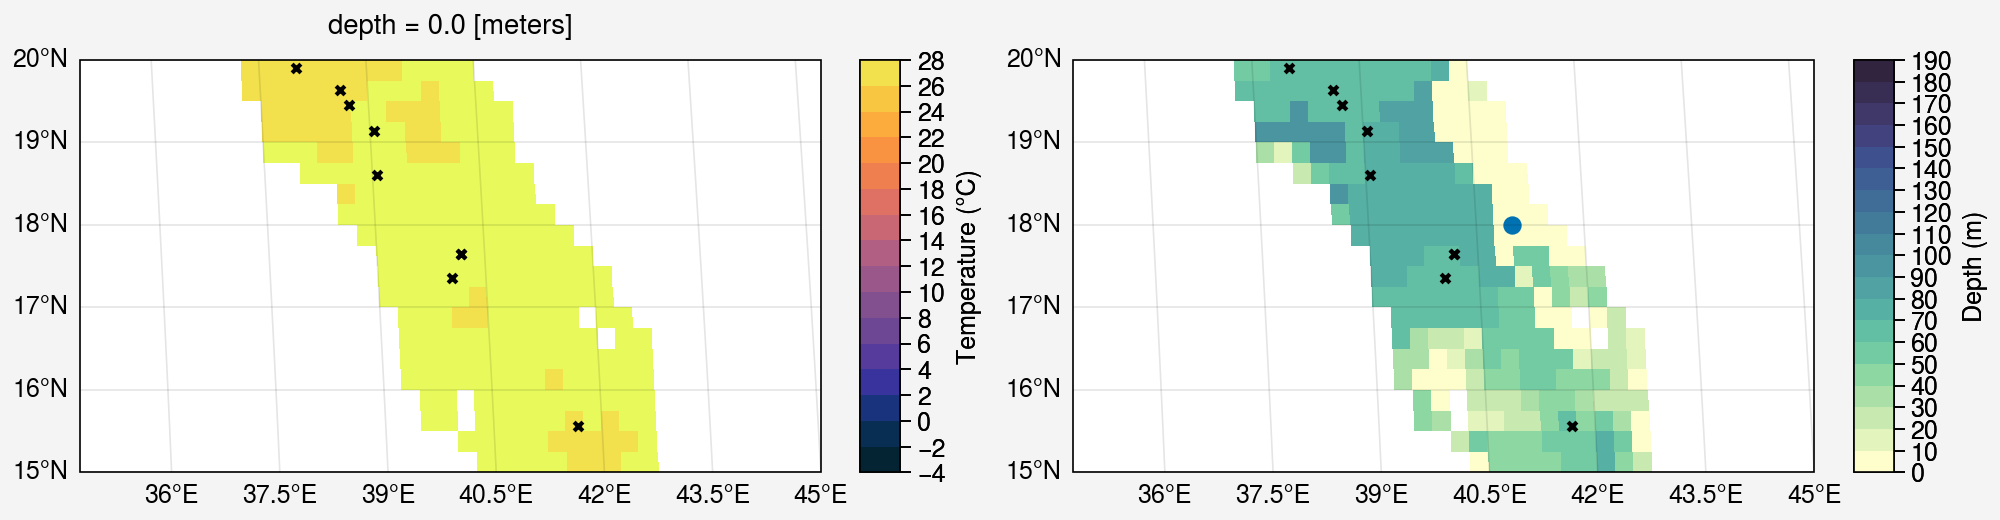

In [87]:
fig, axs = plot.subplots(proj='robin',width=10,ncols=2)
axs.format(
    latlim=(15,20),
    lonlim=(35,45),
    latlabels=True,lonlabels=True
)

ax = axs[0]
thermocline_depthIntegral_T_da.plot(ax=ax,robust=True,
                                    cmap=cmo.thermal,
                                    levels=np.arange(-4,30,2),
                                    cbar_kwargs={'label':'Temperature (°C)'}
                                    )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')

ax = axs[1]
thermoT_depth_da.plot(ax=ax,robust=True,
                cmap=cmo.deep,
                levels=np.arange(0,200,10),
                cbar_kwargs={'label':'Depth (m)'}
                )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')
ax.scatter(41,18)

(<matplotlib.collections.PathCollection at 0x7f81d4915390>,
 <matplotlib.collections.PathCollection at 0x7f81d4915ea0>)

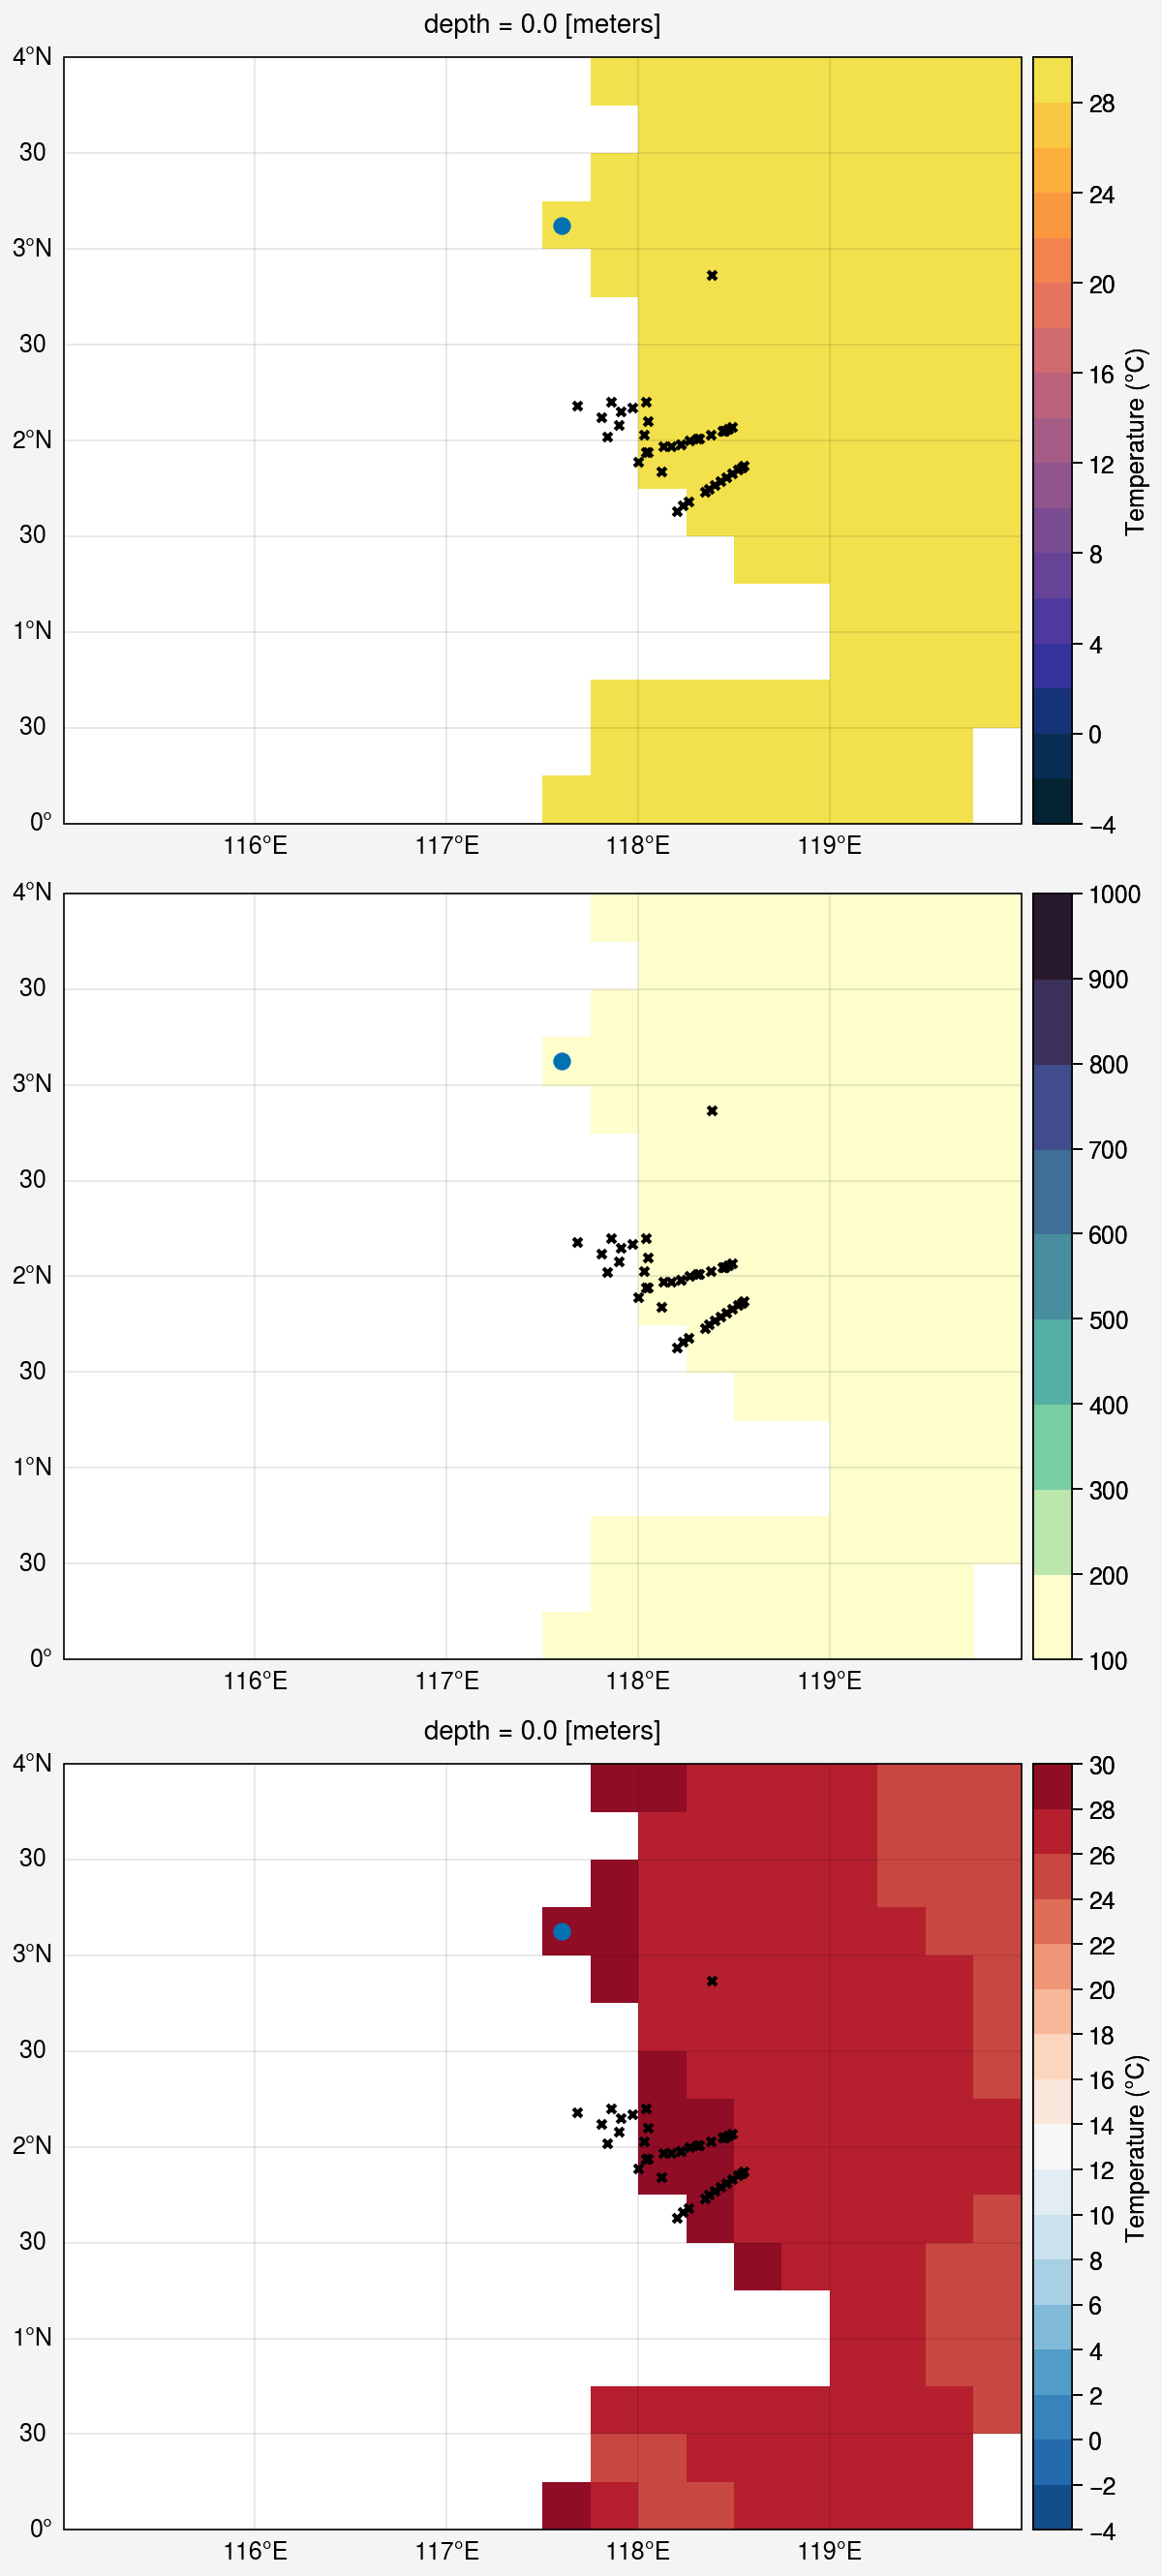

In [89]:
fig, axs = plot.subplots(nrows=3,proj='cyl',width=6)
axs.format(latlim=(0,4),lonlim=(115,120),
           latlabels=True,lonlabels=True,)

ax = axs[0]
aa = T_da.isel(depth=0)
m = aa.plot(ax=ax,
            levels=np.arange(-4,31,2),
            cmap='cmo.thermal',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1]

bb = thermoT_depth_da
m = bb.plot(ax=ax,
            # levels=np.arange(-4,31,2),
            cmap='cmo.deep',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', 
            # label='Temperature (\N{DEGREE SIGN}C)',
            # ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[2]
cc = thermocline_depthIntegral_T_da
m = cc.plot(ax=ax,
            levels=np.arange(-4,31,2),
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,2),
            tickminor=False,
            )

axs.scatter(
    coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops'
)

axs.scatter(117.6,3.125)

In [73]:
T_da.sel(lon=117.5,lat=3.1,method='nearest').dropna('depth').integrate('depth')

<xarray.DataArray 't_an' ()>
array(0., dtype=float32)
Coordinates:
    lat      float32 3.125
    lon      float32 117.6

### 2.2.2 CMEMS Nitrate

CMEMS = Copernicus Marine Environmental Monitoring Service

- Nitrate - Mole concentration of nitrate in sea water 0.25deg x 0.25deg
- Unit: mmol/m3
- Link to data product website: https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/description

- Raw data: monthly climatology hindcasts from 1993-2022 (30 years)
- Processing: The climatology mean field of annual average were generated from 30-year montly climatologies using ncclimo function (https://nco.sourceforge.net/nco.html)

In [16]:
### NEMO nitrate data
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/Marine-Copernicus-Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = r'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

nitrate_CMEMS_ds = xr.open_dataset(os.path.join(fpath,fname))
nitrate_CMEMS_ds = nitrate_CMEMS_ds.rename({'latitude':'lat','longitude':'lon'}).drop('time')
nitrate_CMEMS_da = nitrate_CMEMS_ds.no3.load() ### convert mmol/L to umol/L to make it comparable to WOA data
nitrate_CMEMS_da

depth_coord = nitrate_CMEMS_da.depth
depth_coord = depth_coord - depth_coord[0]
nitrate_CMEMS_da = nitrate_CMEMS_da.assign_coords(depth=depth_coord)
nitrate_CMEMS_da

<xarray.DataArray 'no3' (time: 1, depth: 75, lat: 681, lon: 1440)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [5.7781367, 5.779535 , 5.7808266, ..., 5.7733583, 5.775043 ,
          5.7766376],
         [5.720044 , 5.7206492, 5.721291 , ..., 5.718462 , 5.7189493,
          5.719477 ],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -80.0 -79.75 -79.5 -79.25 ... 89.25 89.5 89.75 90.0
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [17]:
### regrid nitrate_CMESM to T_an grid
nitrate_CMEMS_da_regrid_ll = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,method='linear')
display(nitrate_CMEMS_da_regrid_ll)

nitrate_CMEMS_da_regrid_lld = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,depth=T_da.depth,method='linear')
nitrate_CMEMS_da_regrid_lld

<xarray.DataArray 'no3' (time: 1, depth: 75, lat: 720, lon: 1440)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
                nan],
         [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

<xarray.DataArray 'no3' (time: 1, depth: 102, lat: 720, lon: 1440)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
                nan],
         [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [91]:
masked_nitrate_regrid_lld_da = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["depth"]<=thermoT_depth_da)
masked_tmp_grid = masked_nitrate_regrid_lld_da
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
thermocline_depthIntegral_nitrate_da = tmp_da
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(thermocline_depthIntegral_nitrate_da)

tmp_da2 = tmp_da2.where(~all_nan_mask)
thermocline_nitrate_da = tmp_da2
display(thermocline_nitrate_da)


<xarray.DataArray (time: 1, lat: 720, lon: 1440)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [7.5698457, 7.572421 , 7.5749416, ..., 7.561945 , 7.5645914,
               nan],
        [7.498859 , 7.4996924, 7.500496 , ..., 7.496213 , 7.4971166,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 0.0
Dimensions without coordinates: time

<xarray.DataArray (time: 1, lat: 720, lon: 1440)>
array([[[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        ...,
        [9.325234, 9.326268, 9.32728 , ..., 9.322065, 9.323127,
              nan],
        [9.300414, 9.300759, 9.301102, ..., 9.299388, 9.299727,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 1e+03
Dimensions without coordinates: time

### 2.2.3 WOA23 Nitrate

In [19]:
### WOA23 nitrate data
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
fname = r'woa23_all_n00_01.nc'

nitrate_WOA23_da = xr.open_dataset(os.path.join(fpath2,fname),decode_times=False).n_an.load()
nitrate_WOA23_da

<xarray.DataArray 'n_an' (time: 1, depth: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.5065072 , 0.5077519 , 0.50824255, ..., 0.49354407,
          0.49962154, 0.50394267],
         [0.5509077 , 0.552426  , 0.55362046, ..., 0.53350955,
          0.5418536 , 0.54766   ],
         [0.5734835 , 0.5734835 , 0.5734835 , ..., 0.5734835 ,
          0.5734835 , 0.5734835 ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 3.894e+03
Attributes:
    standard_name:  moles_of_nitrate_per_unit_mass_in_sea_water
    long_name:      Objectively analyzed mean fields for moles_of_nitrate_per...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

In [20]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sel_T_da = T_da_01
sliced_T_da = sel_T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(sel_T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_01_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_01_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_01_depth_values = thermoT_01_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_01_values = thermoT_01_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_01_depth_da = thermoT_01_depth_values.unstack("grid")
thermoT_01_da = thermoT_01_values.unstack("grid")



In [92]:
masked_nitrate_WOA23 = nitrate_WOA23_da.where(nitrate_WOA23_da["depth"]<=thermoT_01_depth_da)
masked_tmp_grid = masked_nitrate_WOA23
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_01_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
WOA23_thermocline_depthIntegral_nitrate_da = tmp_da
WOA23_thermocline_depthIntegral_nitrate_da = WOA23_thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(WOA23_thermocline_depthIntegral_nitrate_da)
tmp_da2 = tmp_da2.where(~all_nan_mask)
WOA23_thermocline_nitrate_da = tmp_da2
display(WOA23_thermocline_nitrate_da)


<xarray.DataArray (time: 1, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.9040422, 5.9228544, 5.946482 , ..., 5.8460336, 5.8687625,
         5.88737  ],
        [5.67362  , 5.685511 , 5.6993546, ..., 5.6302495, 5.6478033,
         5.661916 ],
        [5.414655 , 5.414655 , 5.414655 , ..., 5.414655 , 5.414655 ,
         5.414655 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 3.894e+03

<xarray.DataArray (time: 1, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [11.059551 , 11.109554 , 11.168578 , ..., 10.905602 ,
         10.963257 , 11.0125885],
        [10.045896 , 10.079221 , 10.116056 , ...,  9.940072 ,
          9.9796095, 10.013854 ],
        [ 8.903845 ,  8.903845 ,  8.903845 , ...,  8.903845 ,
          8.903845 ,  8.903845 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) float32 3.894e+03

Text(0.025, 0.025, '$\\rho$: -0.4859\np: 0.0000')

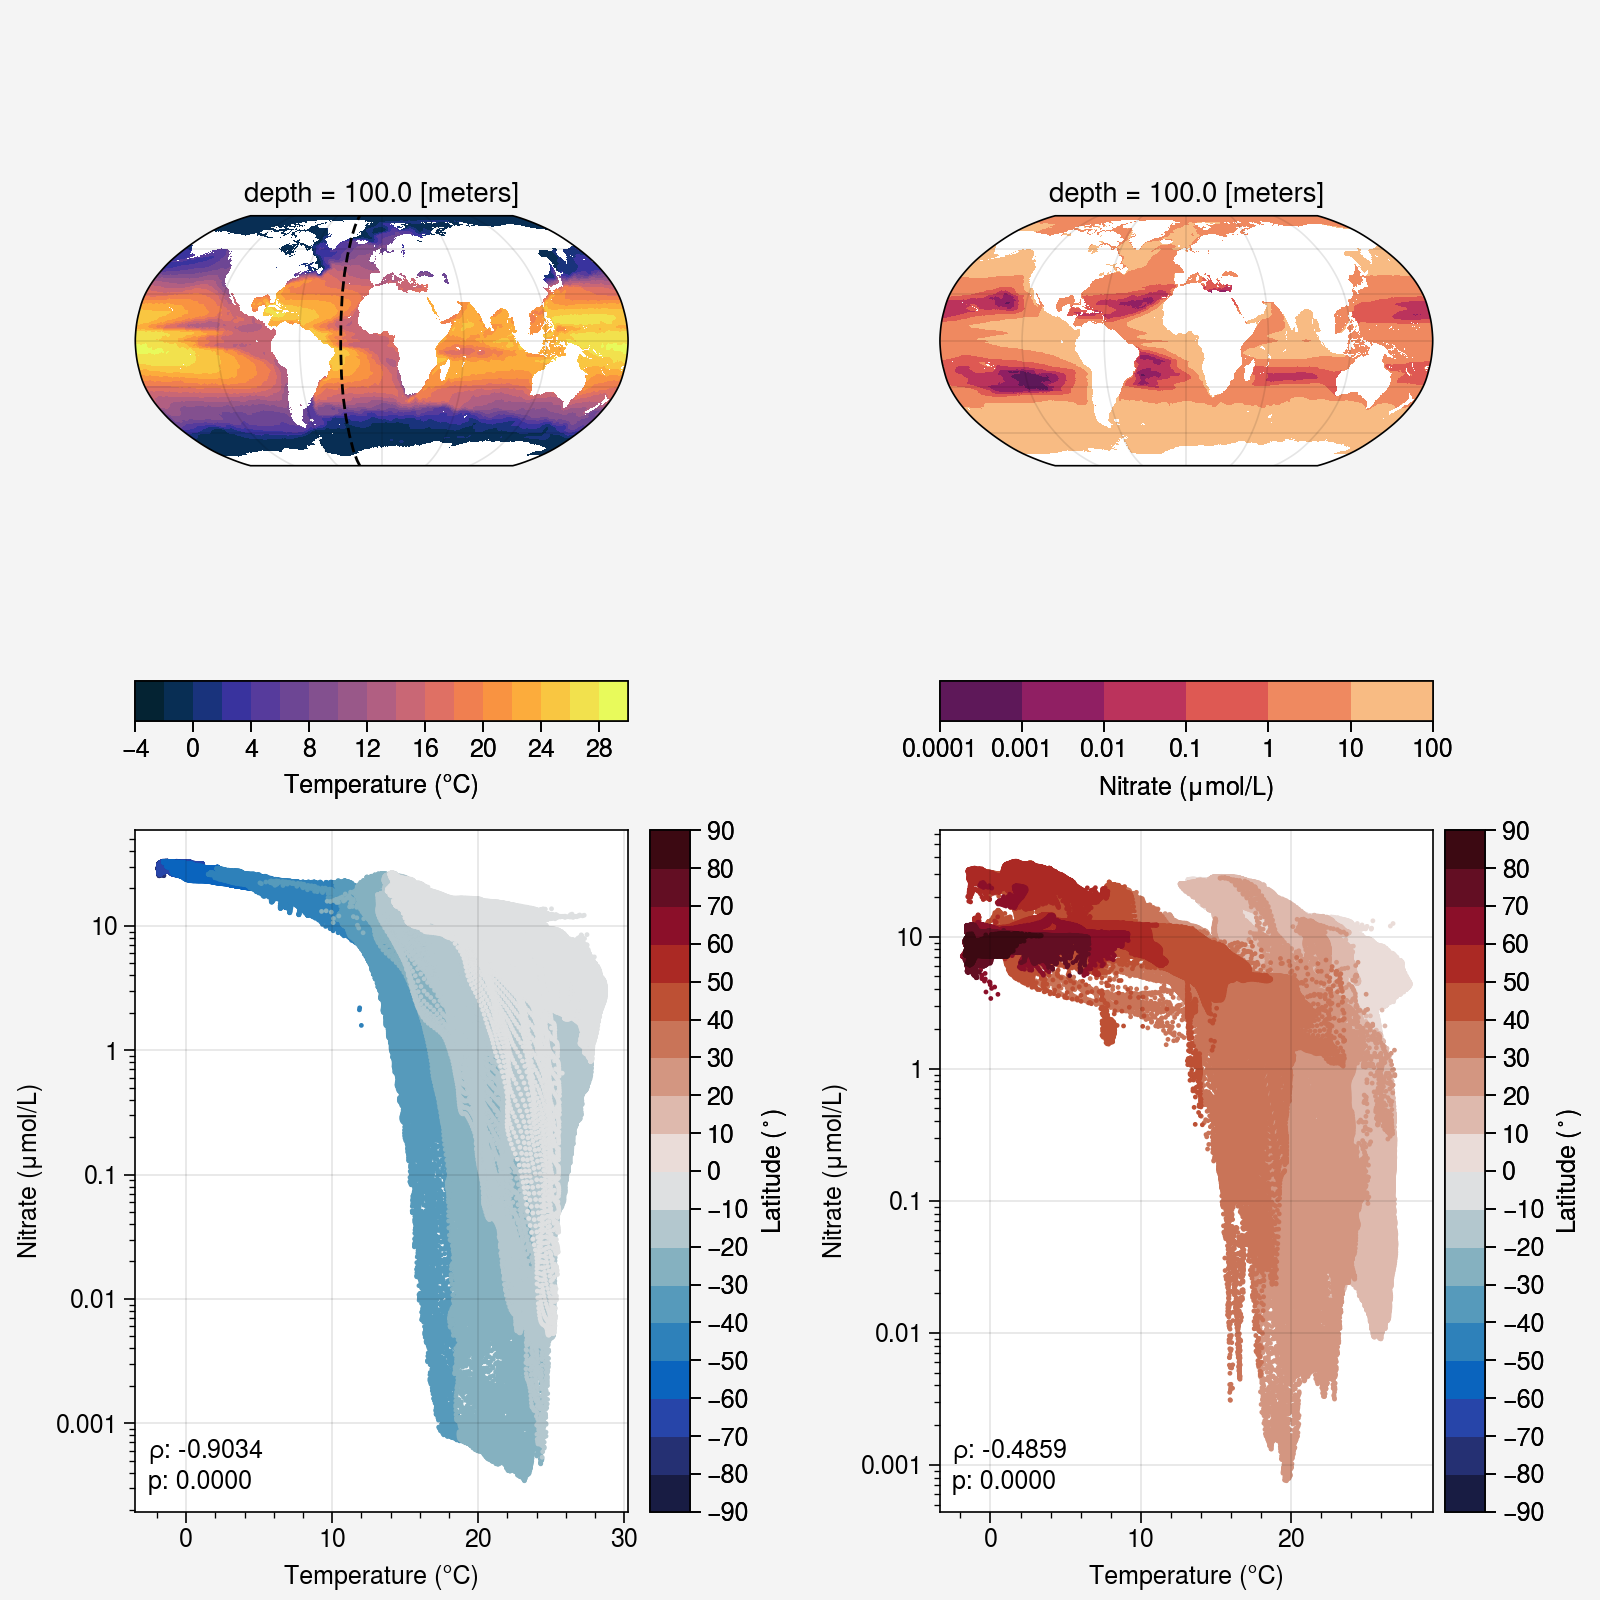

In [93]:
array = [
    [1,2],
    [3,4],
]
fig, axs = plot.subplots(
    array,
    proj=('robin','robin',None),
    figsize=(8,8),
    share=False)
ax = axs[0,0]
m = T_da.sel(depth=100,method='nearest').plot(ax=ax,
                        levels=np.arange(-4,31,2),
                        cmap='cmo.thermal',
                        add_colorbar=False,
                        )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

### plot lon line at -30
ax.plot([-30,-30],[-90,90],'k--',lw=1)

ax = axs[0,1]
m = nitrate_CMEMS_da_regrid_lld.sel(depth=100,method='nearest').plot(ax=ax,
                        robust=True,
                        cmap='cmo.matter_r',
                        add_colorbar=False,
                        levels=[1e-4,1e-3,1e-2,1e-1,1,10,100],
                        )
ax.colorbar(m, loc='b', label='Nitrate ($\mu$mol/L)',
            ticks=[1e-4,1e-3,1e-2,1e-1,1,10,100],
            tickminor=False,
            )


ax = axs[1,0]
plot_x = T_da.where(T_da["lat"]<0).sel(depth=100,method='nearest').values.flatten()
plot_y = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["lat"]<0).sel(depth=100,method='nearest').values.flatten()
nonnan_idx = np.where((~np.isnan(plot_x)) & (~np.isnan(plot_y)))
plot_x = plot_x[nonnan_idx]
plot_y = plot_y[nonnan_idx]
plot_lat = T_da.where(T_da["lat"]<0).sel(depth=100,method='nearest').to_dataframe().reset_index()['lat'].values[nonnan_idx]

m = ax.scatter(plot_x,plot_y,m='.',c=plot_lat,cmap='Balance',s=5,
               levels=np.arange(-90,91,10),
)
ax.format(xlabel='Temperature (\N{DEGREE SIGN}C)',ylabel='Nitrate ($\mu$mol/L)',
          yscale='log',xscale='linear',)
ax.colorbar(m,label='Latitude ($^\circ$)',loc='r')
### calculate the correlation coefficient
rho, pval = spearmanr(plot_x,plot_y)

ax.text(0.025,0.025,f'$\\rho$: {rho:.4f}\np: {pval:.4f}',transform=ax.transAxes,ha='left',va='bottom')

ax = axs[1,1]
plot_x = T_da.where(T_da["lat"]>0).sel(depth=100,method='nearest').values.flatten()
plot_y = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["lat"]>0).sel(depth=100,method='nearest').values.flatten()
nonnan_idx = np.where((~np.isnan(plot_x)) & (~np.isnan(plot_y)))
plot_x = plot_x[nonnan_idx]
plot_y = plot_y[nonnan_idx]
plot_lat = T_da.where(T_da["lat"]>0).sel(depth=100,method='nearest').to_dataframe().reset_index()['lat'].values[nonnan_idx]

m = ax.scatter(plot_x,plot_y,m='.',c=plot_lat,cmap='Balance',s=5,
               levels=np.arange(-90,91,10),
)
ax.format(xlabel='Temperature (\N{DEGREE SIGN}C)',ylabel='Nitrate ($\mu$mol/L)',
          yscale='log',xscale='linear',)
ax.colorbar(m,label='Latitude ($^\circ$)',loc='r')
### calculate the correlation coefficient
rho, pval = spearmanr(plot_x,plot_y)

ax.text(0.025,0.025,f'$\\rho$: {rho:.4f}\np: {pval:.4f}',transform=ax.transAxes,ha='left',va='bottom')

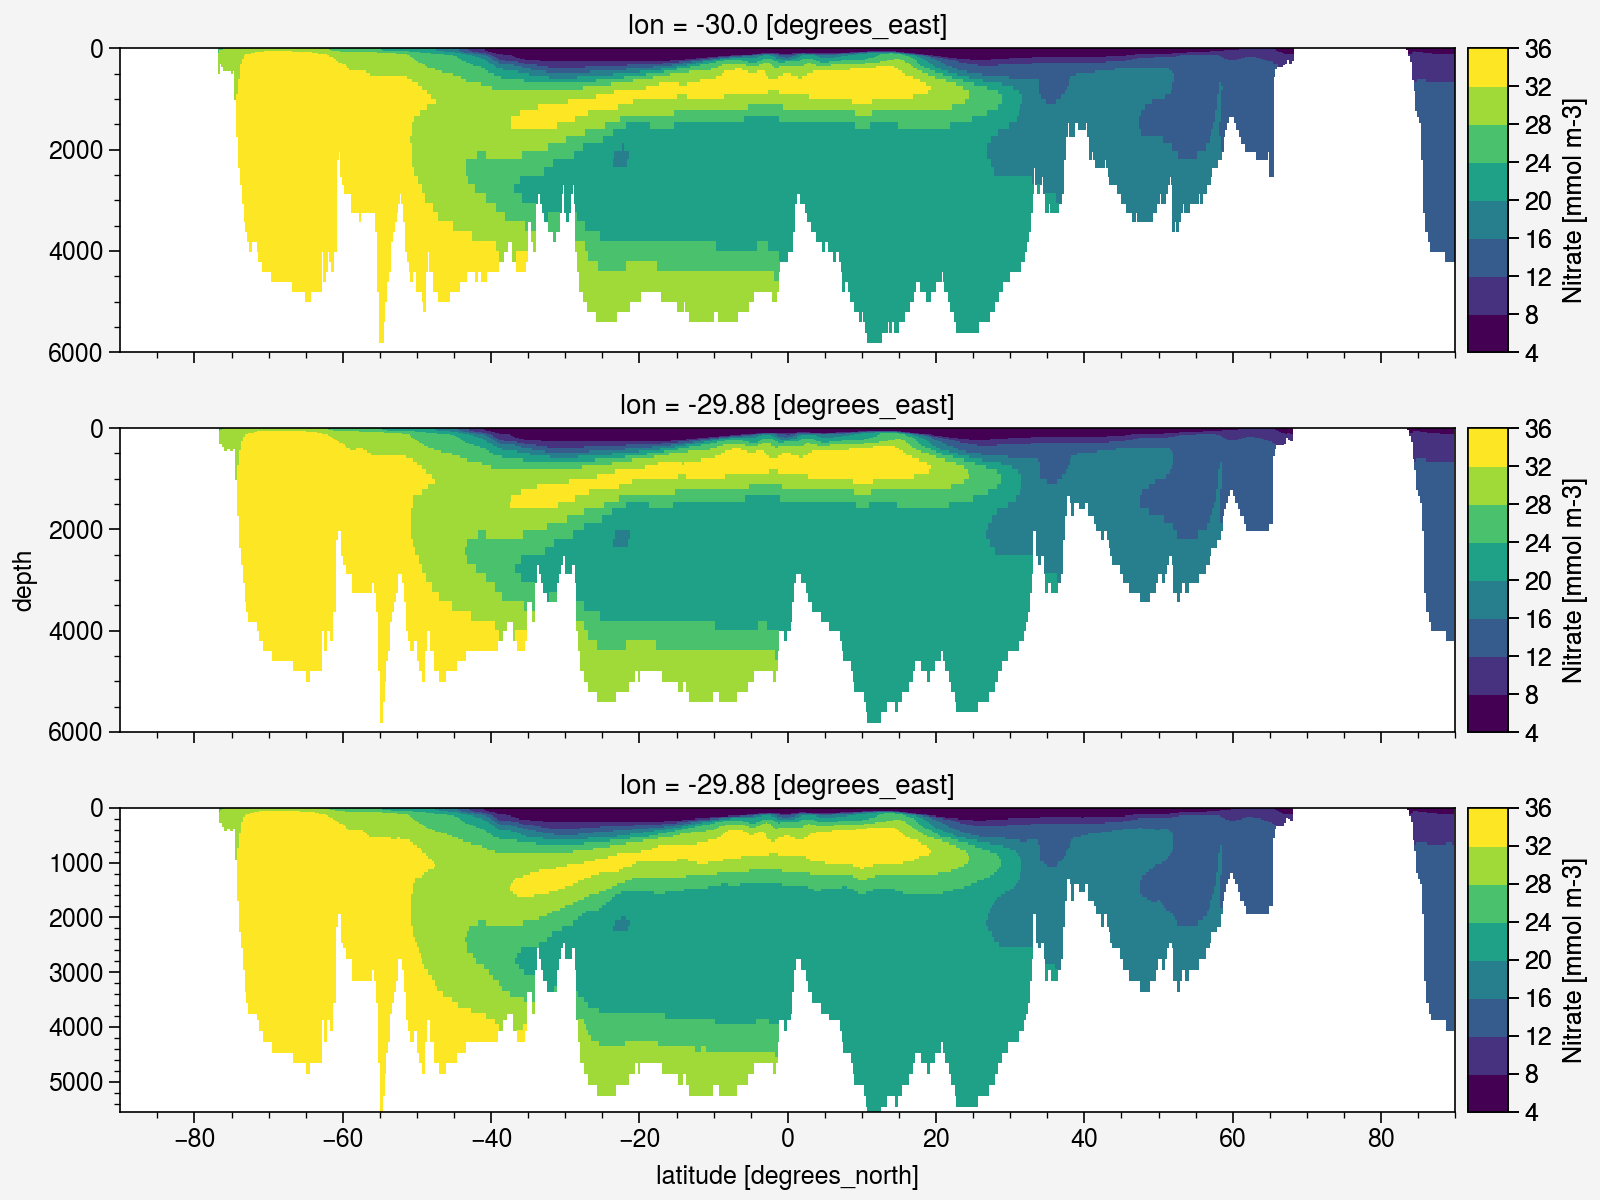

In [94]:
fig, axs = plot.subplots(nrows=3,figsize=(8,6))
sel_lon = -30
ax = axs[0]
nitrate_CMEMS_da.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[1]
nitrate_CMEMS_da_regrid_ll.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[2]
nitrate_CMEMS_da_regrid_lld.sel(lon=sel_lon,method='nearest').plot(ax=ax)

axs.format(
    yreverse=True,
)

In [ ]:
# #### save all calculated dataarrays to netcdf
# fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'

# fname = 'CMEMS_thermocline_nitrate_integral_011625.nc'
# thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate').to_netcdf(os.path.join(fpath,fname))

# fname = 'CMEMS_thermocline_nitrate_011625.nc'
# thermocline_nitrate_da.rename('thermocl_nitrate').to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_integral_011625.nc'
# WOA23_thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate').to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_011625.nc'
# WOA23_thermocline_nitrate_da.rename('thermocl_nitrate').to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depthIntegral_T_011625.nc'
# thermocline_depthIntegral_T_da.rename('thermocl_depthIntg_T').to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depth_011625.nc'
# thermoT_depth_da.rename('thermocl_depth').to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_T_011625.nc'
# thermoT_da.rename('thermocl_T').to_netcdf(os.path.join(fpath,fname))

# 3. Pre-processing

## 3.1 Temperature and thermoclines

In [98]:
##### Calculated clines depth and integrated and weighted integral values
cline_calculation_method = []
tmp_SST = []
thermocline_depth = []
thermocline_T = []
thermocline_T_depthIntegral = []
thermocline_T_weightedIntegral = []

            

coretop_df2['SST'] = [T_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                               method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_depth'] = [thermoT_depth_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_T'] = [thermoT_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_T_depthIntegral'] = [thermocline_depthIntegral_T_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                                method='nearest').values for i in range(len(coretop_df2))]
    
coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,23.5915,30.0,20.44921,22.447308,4.094641,9.728418,5.934224,5.557864,10.865924,7.603764
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,21.89461,15.0,20.246809,21.175428,4.326240,6.462469,4.969550,6.466127,9.033489,7.690656
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,22.92489,20.0,20.120491,21.640024,3.517715,7.672256,4.840915,6.466127,9.033489,7.690656
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,21.70829,35.0,18.52969,20.469841,4.120540,11.105642,6.493748,6.289342,12.159968,8.703465
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,22.3646,35.0,19.3009,21.23381,5.059356,10.533526,6.708450,6.482422,12.270123,8.719608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,25.81369,65.0,22.406591,24.507648,0.160042,0.908693,0.170105,0.536171,1.967975,0.827195
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,25.7189,65.0,22.3758,24.396751,0.175227,1.110894,0.258762,0.536171,1.967975,0.827195
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,25.984491,35.0,24.45329,25.438898,0.178591,0.058804,0.105737,0.515824,1.079724,0.563984
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,26.65379,55.0,23.47081,25.55594,0.122501,0.179089,0.064845,0.547781,1.573383,0.846152


## 3.2 Nitrate concentrations

In [99]:
### calculate integrated nitrate values to the thermocline depth
                

coretop_df2['SSN'] = [nitrate_CMEMS_da_regrid_lld.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                    lon=coretop_df2['Longitude'].iloc[i],
                                                                    method='nearest').values[0] for i in range(len(coretop_df2))]

coretop_df2['thermocline_nitrate'] = [thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['thermocline_nitrate_depthIntegral'] = [thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                                            method='nearest').values[0] for i in range(len(coretop_df2))]

coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,23.5915,30.0,20.44921,22.447308,4.094641,9.728418,5.934224,5.557864,10.865924,7.603764
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,21.89461,15.0,20.246809,21.175428,4.326240,6.462469,4.969550,6.466127,9.033489,7.690656
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,22.92489,20.0,20.120491,21.640024,3.517715,7.672256,4.840915,6.466127,9.033489,7.690656
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,21.70829,35.0,18.52969,20.469841,4.120540,11.105642,6.493748,6.289342,12.159968,8.703465
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,22.3646,35.0,19.3009,21.23381,5.059356,10.533526,6.708450,6.482422,12.270123,8.719608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,25.81369,65.0,22.406591,24.507648,0.160042,0.908693,0.170105,0.536171,1.967975,0.827195
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,25.7189,65.0,22.3758,24.396751,0.175227,1.110894,0.258762,0.536171,1.967975,0.827195
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,25.984491,35.0,24.45329,25.438898,0.178591,0.058804,0.105737,0.515824,1.079724,0.563984
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,26.65379,55.0,23.47081,25.55594,0.122501,0.179089,0.064845,0.547781,1.573383,0.846152


In [100]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['WOA23_SSN'] = [nitrate_WOA23_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate'] = [WOA23_thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                            method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate_depthIntegral'] = [WOA23_thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                                        lon=coretop_df2['Longitude'].iloc[i],
                                                                                                        method='nearest').values[0] for i in range(len(coretop_df2))]

coretop_df2

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,SST,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,23.5915,30.0,20.44921,22.447308,4.094641,9.728418,5.934224,5.557864,10.865924,7.603764
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,21.89461,15.0,20.246809,21.175428,4.326240,6.462469,4.969550,6.466127,9.033489,7.690656
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,22.92489,20.0,20.120491,21.640024,3.517715,7.672256,4.840915,6.466127,9.033489,7.690656
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,21.70829,35.0,18.52969,20.469841,4.120540,11.105642,6.493748,6.289342,12.159968,8.703465
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,22.3646,35.0,19.3009,21.23381,5.059356,10.533526,6.708450,6.482422,12.270123,8.719608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,25.81369,65.0,22.406591,24.507648,0.160042,0.908693,0.170105,0.536171,1.967975,0.827195
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,25.7189,65.0,22.3758,24.396751,0.175227,1.110894,0.258762,0.536171,1.967975,0.827195
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,25.984491,35.0,24.45329,25.438898,0.178591,0.058804,0.105737,0.515824,1.079724,0.563984
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,26.65379,55.0,23.47081,25.55594,0.122501,0.179089,0.064845,0.547781,1.573383,0.846152


## 3.3 Hand-labelling region name

In [101]:
##### Load spreadsheet with manually-assigned region names for coretops
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'manual_regionName_assignment_010425'
manual_regionName_df = pd.read_excel(os.path.join(fpath,fname+'.xlsx'),sheet_name='master_regionName')
manual_regionName_df = manual_regionName_df.rename(columns={'Sample ID':'sampleID',
                                                            'region_description':'regionName'})

coretop_df_full = pd.concat([coretop_df2.set_index('sampleID'),
                             manual_regionName_df.set_index('sampleID')],axis=1).reset_index(drop=False).dropna(subset=['core_name'])
coretop_df_full = coretop_df_full.loc[:,~coretop_df_full.columns.duplicated()]
coretop_df_full

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,WOA23_SSN,WOA23_thermocline_nitrate,WOA23_thermocline_nitrate_depthIntegral,region_ID,regionName
0,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,20.44921,22.447308,4.094641,9.728418,5.934224,5.557864,10.865924,7.603764,10.0,East Equatorial Pacific
1,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,20.246809,21.175428,4.326240,6.462469,4.969550,6.466127,9.033489,7.690656,10.0,East Equatorial Pacific
2,TEXAS_PSM_RR00007,KNR195-5 MC25,MC,5.0,7.0,-3.5830,-81.1650,381.0,0.617192,0.292011,...,20.120491,21.640024,3.517715,7.672256,4.840915,6.466127,9.033489,7.690656,10.0,East Equatorial Pacific
3,TEXAS_PSM_RR00008,KNR195-5 MC33,MC,3.0,5.0,-3.2237,-82.9142,2949.0,0.605147,0.309270,...,18.52969,20.469841,4.120540,11.105642,6.493748,6.289342,12.159968,8.703465,10.0,East Equatorial Pacific
4,TEXAS_PSM_RR00009,KNR195-5 MC34,MC,4.0,6.0,-3.5975,-83.9632,3224.0,0.588670,0.344233,...,19.3009,21.23381,5.059356,10.533526,6.708450,6.482422,12.270123,8.719608,10.0,East Equatorial Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,22.406591,24.507648,0.160042,0.908693,0.170105,0.536171,1.967975,0.827195,38.0,South China Sea
2018,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,22.3758,24.396751,0.175227,1.110894,0.258762,0.536171,1.967975,0.827195,38.0,South China Sea
2019,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,24.45329,25.438898,0.178591,0.058804,0.105737,0.515824,1.079724,0.563984,38.0,South China Sea
2020,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,23.47081,25.55594,0.122501,0.179089,0.064845,0.547781,1.573383,0.846152,38.0,South China Sea


In [102]:
# fpath = os.path.join(local_github_path,'spreadsheets')
# fname = 'coretop_df_full_011525_tmp'
# coretop_df_full.to_csv(os.path.join(fpath,fname+'.csv'),index=False)


### Create regionName color_dict

In [30]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df_full['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

{'East Equatorial Pacific': '#1f77b4ff',
 'Mozambique Channel': '#fb800fff',
 'Pacific-Southern Ocean': '#5e7c2bff',
 'Tasman-Antarctica 140E Transect': '#b04b7dff',
 'NZ-SW Pacific': '#8f5d7aff',
 'Equatorial Pacific': '#d772b2ff',
 'West Equatorial Pacific': '#878872ff',
 'Tonga-Tropical South Pacific': '#78bd69ff',
 'South China Sea': '#2685aaff',
 'Chilean Offshore': '#4b4d97ff',
 'Southern Ocean Front-Atlantic': '#6b6dceff',
 'Arctic Ocean': '#8d95b4ff',
 'Eastern North America Offshore': '#6e8440ff',
 'Drake Passage': '#a3bb60ff',
 'Barent Sea (open sea)': '#cad993ff',
 'Amundsen Sea': '#917232ff',
 'North Atlantic': '#c2a13cff',
 'Hudson Bay': '#e7c16cff',
 'Eastern South America Offshore': '#a56c57ff',
 'Barent Sea (100km from NOR_shore)': '#ab4849ff',
 'Ross Sea': '#d4606aff',
 'Japan Sea': '#ce8292ff',
 'North Sea': '#904984ff',
 'Baltic Sea': '#c567b4ff',
 'South Atlantic Gyre': '#db94d1ff',
 'Greenland Sea': '#148ac8ff',
 'South Africa Offshore': '#f47133ff',
 'Northern Pac

In [31]:
import plotly.express as px

fig = px.scatter_geo(coretop_df_full, 
                     lon='Longitude', 
                     lat='Latitude', 
                     color='regionName', 
                     title='Coretop Locations by Region')

fig.update_geos(projection_type="robinson", 
                showland=True, 
                landcolor="lightgray")

fig.show()